In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import shutil
import torch
from time import  strftime
import os, sys, time
import cv2
import PIL
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import widgets as wdg  # Using the ipython notebook widgets
import json
from pathlib import Path

from src.utils.preprocess import CropAndExtract
from src.test_audio2coeff import Audio2Coeff  
from src.facerender.animate import AnimateFromCoeff
from src.generate_batch import get_data
from src.generate_facerender_batch import get_facerender_data
from src.utils.init_path import init_path
from src.utils.croper import Preprocesser

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
pic_path2 = "/Users/jannisnecker/Desktop/IMG_2738.jpg"

In [6]:
pic_path = "./examples/source_image/happy.png"
save_dir = os.path.join("./results", "manual")
os.makedirs(save_dir, exist_ok=True)
pose_style = 0
device = "cpu"
batch_size = 2
input_yaw_list = None
input_pitch_list = None
input_roll_list = None
ref_eyeblink = None
ref_pose = None

size = 256
old_version = False
preprocess = "resize"
still = False
expression_scale = 1.
enhancer = "gfpgan"
background_enhancer = None

current_root_path = os.path.split(sys.argv[0])[0]

sadtalker_paths = init_path(
    "./checkpoints", 
    './src/config', 
    size, 
    old_version, 
    preprocess
)

#init model
preprocess_model = CropAndExtract(sadtalker_paths, device)
audio_to_coeff = Audio2Coeff(sadtalker_paths,  device)
animate_from_coeff = AnimateFromCoeff(sadtalker_paths, device)

full_frames = [cv2.imread(pic_path)]
x_full_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in full_frames] 

p = Preprocesser("cpu")

In [7]:
lm = p.get_landmark(full_frames[0])
global lm2
lm2 = np.zeros((68, 2))

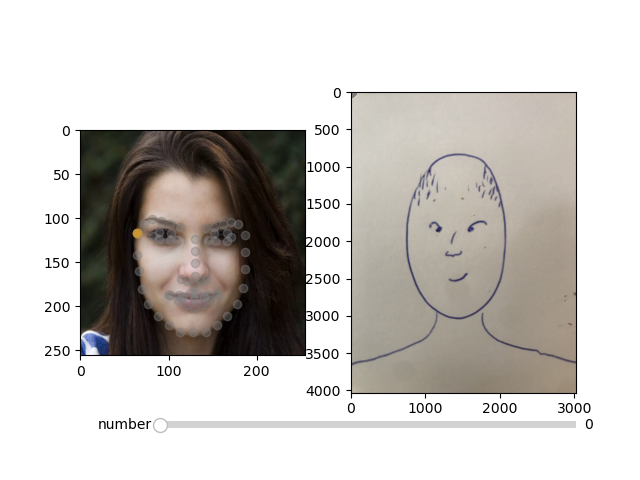

In [8]:
im = plt.imread(pic_path)
im2 = plt.imread(pic_path2)


fig, (ax1, ax2) = plt.subplots(ncols=2)

def show_landmark(i):
    for ax, ilm, iim in zip([ax1, ax2], [lm, lm2], [im, im2]):
        ax.clear()
        ax.imshow(iim)
        if len(ilm) >= i:
            ax.scatter(*ilm[i].T, color="orange")
        ax.scatter(*ilm.T, alpha=0.4, color="grey")

show_landmark(0)

amp_slider = wdg.Slider(
    ax=fig.add_axes([0.25, 0.1, 0.65, 0.03]),
    label="number",
    valmin=0,
    valmax=len(lm) - 1,
    valinit=0,
    valstep=1,
)
amp_slider.on_changed(show_landmark)

# Define a callback function that will update the textarea
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print (f'x = {ix}, y = {iy}')
    lm2[amp_slider.val] = (ix, iy)
    
    if len(lm2) == 2:
        fig.canvas.mpl_disconnect(cid)
        
    amp_slider.set_val(amp_slider.val + 1)
    
    show_landmark(i)
    fig.canvas.draw()

    return coords

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)
    

In [20]:
landmarks_path = Path(save_dir) / "first_frame_dir" / f"{Path(pic_path2).stem}_landmarks.txt"
np.savetxt(landmarks_path, lm2.reshape(-1))
print(f"saved to {landmarks_path}")